In [ ]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Get Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive

Mounted at /content/gdrive


In [ ]:
!cp /mydrive/dataset/images.zip ./

In [ ]:
!ls

data  data.zip	gdrive	images.zip  sample_data


In [ ]:
!unzip ./images.zip -d ./

Streaming output truncated to the last 5000 lines.
 extracting: ./images/validation/fear/9101.jpg  
 extracting: ./images/validation/fear/911.jpg  
 extracting: ./images/validation/fear/9179.jpg  
 extracting: ./images/validation/fear/9205.jpg  
 extracting: ./images/validation/fear/9232.jpg  
 extracting: ./images/validation/fear/9251.jpg  
 extracting: ./images/validation/fear/9261.jpg  
 extracting: ./images/validation/fear/9281.jpg  
 extracting: ./images/validation/fear/9302.jpg  
 extracting: ./images/validation/fear/9333.jpg  
 extracting: ./images/validation/fear/9369.jpg  
 extracting: ./images/validation/fear/9370.jpg  
 extracting: ./images/validation/fear/9474.jpg  
 extracting: ./images/validation/fear/949.jpg  
 extracting: ./images/validation/fear/9602.jpg  
 extracting: ./images/validation/fear/9606.jpg  
 extracting: ./images/validation/fear/9842.jpg  
 extracting: ./images/validation/fear/9898.jpg  
   creating: ./images/validation/happy/
 extracting: ./images/validat

In [ ]:
from __future__ import print_function, division
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

data_dir = "./images"
input_shape = 48


#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize((0,), (255,))
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize((0,), (255,))
   ]),
}

image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=64,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device : ",device)

{'train': 28821, 'validation': 7066}
device :  cuda:0


In [ ]:
class_names = image_datasets['train'].classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
print(len(dataloaders['train']), len(image_datasets['train']))
print(len(dataloaders['validation']), len(image_datasets['validation']))


451 28821
111 7066


{'train': 28821, 'validation': 7066}
torch.Size([3, 48, 48])


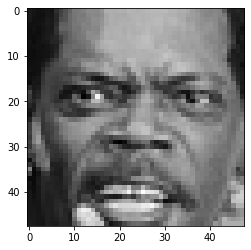

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
print(dataset_sizes)
first_image = image_datasets['train'][2][0]
print(first_image.shape)
plt.imshow(first_image[0],cmap='gray')

image shape :  torch.Size([64, 3, 48, 48])


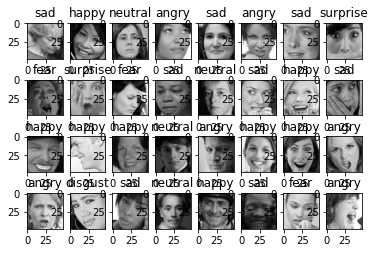

In [ ]:
images, labels = next(iter(dataloaders['train']))
print("image shape : ",images.shape)

rows = 4
columns = 8
fig=plt.figure()
for i in range(32):
   fig.add_subplot(rows, columns, i+1)
   plt.title(class_names[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = 255 * img + 0
   plt.imshow(img)
plt.show()


# Model-1


In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in resnet50.parameters():
  param.requires_grad = False


resnet50_last_layer_input_size = resnet50.fc.in_features 
layer = torch.nn.Linear(resnet50_last_layer_input_size,len(class_names))
resnet50.fc = layer
print(resnet50.fc)

Linear(in_features=2048, out_features=7, bias=True)


# Model-2

In [ ]:
## Load the model based on resnet18
resnet18 = torchvision.models.resnet18(pretrained=True)

for param in resnet18.parameters():
     param.requires_grad = False
     
"""last_layer_input_counter = resnet18.classifier[6].in_features
classifier_layers = list(resnet18.classifier.children())[:-1]

additional_1 = torch.nn.Linear(last_layer_input_counter, 256)
additional_2 = torch.nn.Linear(256, 64)
additional_3 = torch.nn.Linear(64,len(class_names))

classifier_layers.extend([additional_1,additional_2,additional_3])
resnet18.classifier = torch.nn.Sequential(*classifier_layers)

#print(resnet18)"""

'last_layer_input_counter = resnet18.classifier[6].in_features\nclassifier_layers = list(resnet18.classifier.children())[:-1]\n\nadditional_1 = torch.nn.Linear(last_layer_input_counter, 256)\nadditional_2 = torch.nn.Linear(256, 64)\nadditional_3 = torch.nn.Linear(64,len(class_names))\n\nclassifier_layers.extend([additional_1,additional_2,additional_3])\nresnet18.classifier = torch.nn.Sequential(*classifier_layers)\n\n#print(resnet18)'

In [ ]:
class Util():
    def training_step(self, batch, model):
        images, labels = batch 
        out = model(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = self.accuracy(out, labels)
        return loss,acc
    
    def validation_step(self, batch, model):
        images, labels = batch 
        out = model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
   
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc:{:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
    
    def accuracy(self,outputs, labels):
      _, preds = torch.max(outputs, dim=1)
      return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    

In [ ]:
@torch.no_grad()
def evaluate(util, val_loader,model):
    model.eval()
    outputs = [util.validation_step(batch,model) for batch in val_loader]
    return util.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        # Training Phase 
        #model.train()
        train_losses = []
        train_acc = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss,acc = util.training_step(batch, model)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()
            optimizer.step()
            
                
        # Validation phase
        result = evaluate(util, val_loader,model)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()

        util.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
util = Util()

# Train-1

In [ ]:
num_epochs = 5
opt_func = optim.SGD
lr = 0.001
history = fit(num_epochs,lr,resnet18,dataloaders['train'],dataloaders['validation'],opt_func)

30  :  tensor(1.8339, grad_fn=<NllLossBackward>)
60  :  tensor(1.8467, grad_fn=<NllLossBackward>)
90  :  tensor(1.8649, grad_fn=<NllLossBackward>)
120  :  tensor(1.7027, grad_fn=<NllLossBackward>)
150  :  tensor(1.8230, grad_fn=<NllLossBackward>)
180  :  tensor(1.7966, grad_fn=<NllLossBackward>)
210  :  tensor(1.7706, grad_fn=<NllLossBackward>)
240  :  tensor(1.7630, grad_fn=<NllLossBackward>)
270  :  tensor(1.8487, grad_fn=<NllLossBackward>)
300  :  tensor(1.7541, grad_fn=<NllLossBackward>)
330  :  tensor(1.6447, grad_fn=<NllLossBackward>)
360  :  tensor(1.7877, grad_fn=<NllLossBackward>)
390  :  tensor(1.6948, grad_fn=<NllLossBackward>)
420  :  tensor(1.7229, grad_fn=<NllLossBackward>)
450  :  tensor(1.7401, grad_fn=<NllLossBackward>)
Epoch [0], train_loss: 1.7824, val_loss: 1.7052, val_acc: 0.3367
30  :  tensor(1.6738, grad_fn=<NllLossBackward>)
60  :  tensor(1.6615, grad_fn=<NllLossBackward>)
90  :  tensor(1.7084, grad_fn=<NllLossBackward>)
120  :  tensor(1.6328, grad_fn=<NllLossBa

# Train-2

Use Cuda This Time

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(dataloaders['train'], device)
val_dl = DeviceDataLoader(dataloaders['validation'], device)
resnet50 = to_device(resnet50, device);

In [ ]:
num_epochs = 100
lr = 0.0001
opt_func = optim.Adam
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
history = fit(num_epochs,lr,resnet50,train_dl,val_dl,opt_func)


Epoch [0], train_loss: 1.5633, train_acc:0.3933, val_loss: 1.6018, val_acc: 0.3769
Epoch [1], train_loss: 1.5546, train_acc:0.3977, val_loss: 1.6034, val_acc: 0.3750
Epoch [2], train_loss: 1.5473, train_acc:0.3996, val_loss: 1.6014, val_acc: 0.3792
Epoch [3], train_loss: 1.5410, train_acc:0.4059, val_loss: 1.5964, val_acc: 0.3758
Epoch [4], train_loss: 1.5350, train_acc:0.4058, val_loss: 1.5949, val_acc: 0.3781
Epoch [5], train_loss: 1.5282, train_acc:0.4099, val_loss: 1.5956, val_acc: 0.3768
Epoch [6], train_loss: 1.5238, train_acc:0.4121, val_loss: 1.5915, val_acc: 0.3766
Epoch [7], train_loss: 1.5181, train_acc:0.4154, val_loss: 1.5915, val_acc: 0.3800
Epoch [8], train_loss: 1.5128, train_acc:0.4174, val_loss: 1.5889, val_acc: 0.3761
Epoch [9], train_loss: 1.5085, train_acc:0.4184, val_loss: 1.5879, val_acc: 0.3839
Epoch [10], train_loss: 1.5030, train_acc:0.4209, val_loss: 1.5929, val_acc: 0.3731
Epoch [11], train_loss: 1.4995, train_acc:0.4237, val_loss: 1.5864, val_acc: 0.3826
Ep

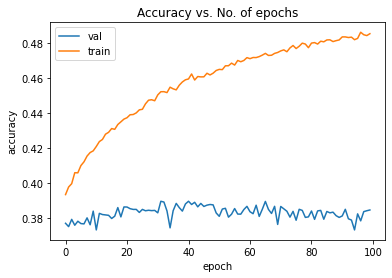

In [ ]:
def plot_accuracies(history):
    val_accuracy = [x['val_acc'] for x in history]
    train_accuracy = [x['train_acc'] for x in history]
    plt.plot(val_accuracy, label = 'val')
    plt.plot(train_accuracy,label = 'train')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

# Save Models

In [ ]:
torch.save(resnet50,"./resnet50")

In [ ]:
torch.save(resnet18,"./model/model_3654")

In [ ]:
model = torch.load("./model/model_3654")
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
result = evaluate(util, dataloaders['validation'],model)
result

{'val_loss': 1.618986964225769, 'val_acc': 0.3666081726551056}